# This is our large neural network model of a route.

The model was intended to learn a relationship between the distance from the first stop on the route, the time of leaving the first stop on the route, the day of the week, and weather condition. This relationship was used to predict the arrival time at any distance of the route.

The data is gathered from individual stop link files. Then any data without the right route id is thrown away.

The distance for each stop on the route from the first stop on the route is found, and added to each corresponding row. 

The time of leaving the first stop is found, and added to each row. Travel time is then calculated as the time of arrival at a stop minus this departure time.

Full date time information is then computed, and the data frame is merged with weather.

Features are scaled, and a sklearn MLPRegressor is trained on the data frame.

In [1]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','rain','temp','day'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(100,100),verbose=True)
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
   

    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        df = df[df['traveltime']>0]
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [2]:
r = BRModel('1',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


In [3]:
train = r.data[r.data['year']==2016]
test = r.data[r.data['year']==2017]

In [4]:
from sklearn.preprocessing import StandardScaler as ss

In [5]:
scaler_X = ss()
X = scaler_X.fit_transform(train[r.features])

In [6]:
scaler_Y = ss()
Y = scaler_Y.fit_transform(train['traveltime'].values.reshape(-1,1))

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
model = r.rgr.fit(X,Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.03579506
Iteration 2, loss = 0.02780701
Iteration 3, loss = 0.02663528
Iteration 4, loss = 0.02577339
Iteration 5, loss = 0.02507498
Iteration 6, loss = 0.02451681
Iteration 7, loss = 0.02409723
Iteration 8, loss = 0.02384071
Iteration 9, loss = 0.02366243
Iteration 10, loss = 0.02342031
Iteration 11, loss = 0.02333099
Iteration 12, loss = 0.02324701
Iteration 13, loss = 0.02307448
Iteration 14, loss = 0.02300359
Iteration 15, loss = 0.02286265
Iteration 16, loss = 0.02274339
Iteration 17, loss = 0.02263890
Iteration 18, loss = 0.02258850
Iteration 19, loss = 0.02245514
Iteration 20, loss = 0.02240499
Iteration 21, loss = 0.02233735
Iteration 22, loss = 0.02222415
Iteration 23, loss = 0.02220330
Iteration 24, loss = 0.02207056
Iteration 25, loss = 0.02206690
Iteration 26, loss = 0.02202334
Iteration 27, loss = 0.02190333
Iteration 28, loss = 0.02192537
Iteration 29, loss = 0.02185100
Iteration 30, loss = 0.02181660
Training loss did not improve more than tol=0.000

In [9]:
preds = scaler_Y.inverse_transform(model.predict(X))
((abs(train['traveltime']-preds)/train['traveltime'])*100).mean()

15.25158872381179

# Scores are surprisingly good when we test the whole model

In [20]:
from sklearn import metrics
real_Y = test['traveltime']
X = scaler_X.transform(test[r.features])
preds = scaler_Y.inverse_transform(model.predict(X))
print(((abs(real_Y-preds)/real_Y)*100).mean())
print(metrics.r2_score(real_Y,preds))

16.576612184486894
0.938767173558468


In [ ]:
# There are negative predictions though

In [21]:
preds.min()

-163.9788332668868

In [23]:
len(preds[preds < 0])

2053

## On closer inspection though

In [12]:
distances = sorted(test['distance'].unique())
ds = []
r2 = []
mape = []
for i in range(0,len(distances)-1):
    distance1 = distances[i]
    distance2 = distances[i+1]
    X = test[(test['distance']>=distance1) & (test['distance'] < distance2)]
    real_Y = X['traveltime']
    X = scaler_X.transform(X[r.features])
    preds =  scaler_Y.inverse_transform(model.predict(X))
    ds.append(distance1)
    from sklearn import metrics
    r2.append(metrics.r2_score(real_Y,preds))
    mape.append(((abs(real_Y - preds)/real_Y)*100).mean())
    print(preds.min())
    
    


-163.9788332668868
-147.27102014162165
-101.0234427524706
-70.52917744695333
-31.267845097918325
39.53184154289352
88.84096849963589
125.39827195493831
159.44863626869756
194.53359186465354
229.52812865281385
263.61833437738824
286.8067675792058
313.78509560462135
359.71743361845483
405.9001563275208
440.4666874107164
502.9863430298727
548.1495282766209
573.7967720325366
707.3813525932707
865.7614866013657
1025.8406000118166
1122.9941134565893
1215.151657673121
1253.8004084008983
1291.3068835923418
1332.3220855407437
1380.8483672456232
1440.1851271096984
1496.4845719878306
1530.622952558849
1590.9875966264383
1621.1332431555195
1647.5547397648913
1694.944612343571
1756.9735777429257
1780.5012589228306
1807.2667373467802


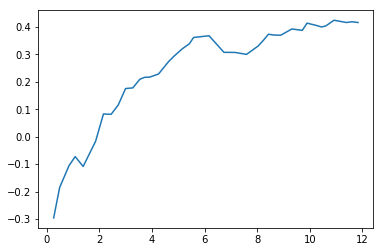

In [16]:
from matplotlib import pyplot as plt
plt.plot(ds,r2)
plt.show()

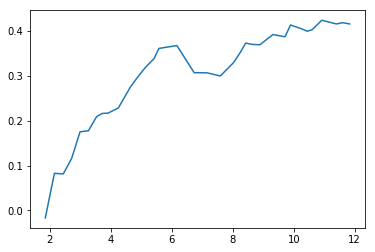

In [14]:
from matplotlib import pyplot as plt
plt.plot(ds[5:],r2[5:])
plt.show()

In [16]:
max(r2)

0.579678378096769

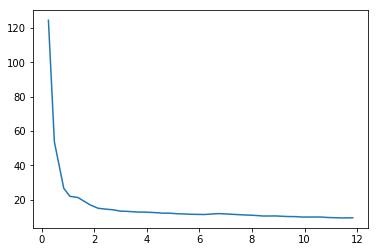

In [17]:
plt.plot(ds,mape)


In [20]:
min(mape)

8.066871460208265

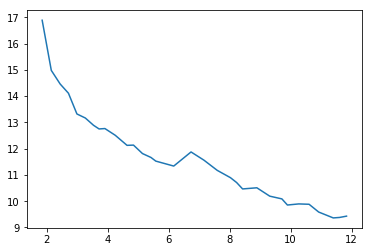

In [18]:
plt.plot(ds[5:],mape[5:])


## Scores for small distances are not very good at all. There are also numerous negative predictions.



In [19]:
preds.min()

1807.2667373467802